In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

/home/navarra/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
df = pd.read_csv("municipality_bus_utilization.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.groupby(['municipality_id', pd.Grouper(key='timestamp', freq='H')])['usage'].max()
df = df.sort_index()

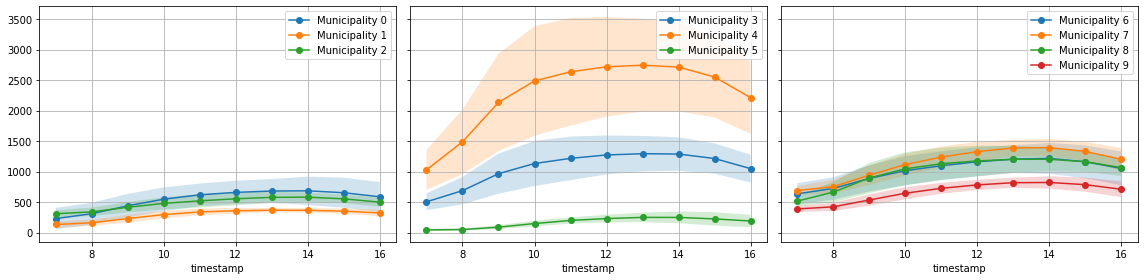

In [3]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
for i in range(3):
    m = df[i].groupby(df[i].index.hour).mean().sort_index().rename(f'Municipality {i}')
    v = df[i].groupby(df[i].index.hour).std().sort_index().rename(f'Municipality {i} - Std')
    m.plot(marker='o', ax=ax[0])
    ax[0].fill_between(m.index, m-v, m+v, alpha=0.2)
ax[0].legend()
ax[0].grid()

# plt.grid()
# plt.subplot(132)
for i in range(3,6):
    m = df[i].groupby(df[i].index.hour).mean().sort_index().rename(f'Municipality {i}')
    v = df[i].groupby(df[i].index.hour).std().sort_index().rename(f'Municipality {i} - Std')
    m.plot(marker='o', ax=ax[1])
    ax[1].fill_between(m.index, m-v, m+v, alpha=0.2)
ax[1].legend()
ax[1].grid()
for i in range(6,10):
    m = df[i].groupby(df[i].index.hour).mean().sort_index().rename(f'Municipality {i}')
    v = df[i].groupby(df[i].index.hour).std().sort_index().rename(f'Municipality {i} - Std')
    m.plot(marker='o', ax=ax[2])
    ax[2].fill_between(m.index, m-v, m+v, alpha=0.2)
ax[2].legend()
ax[2].grid()

plt.tight_layout()

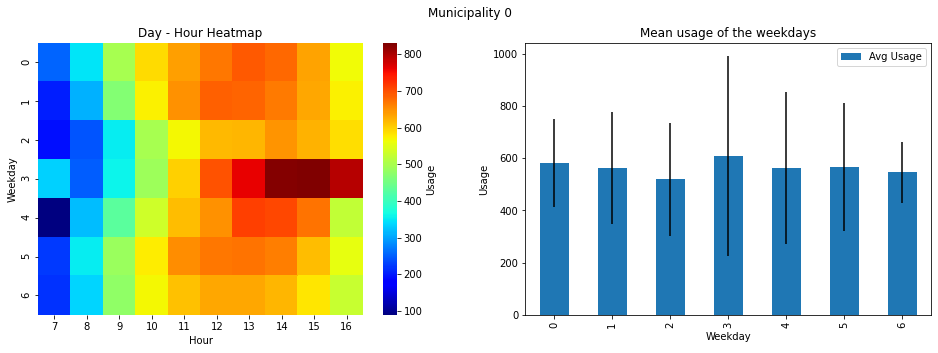

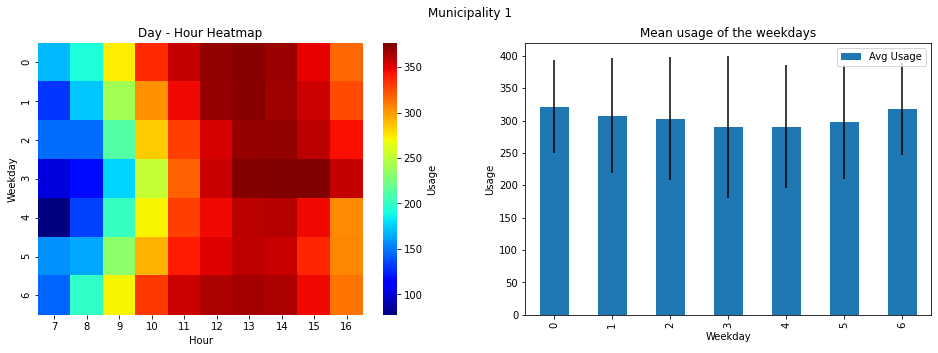

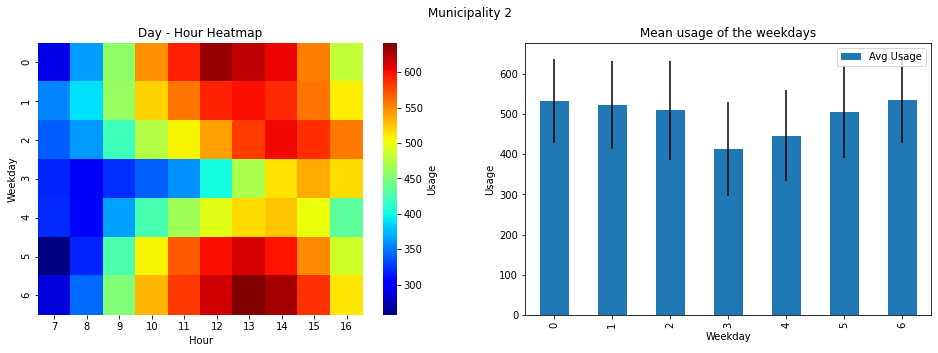

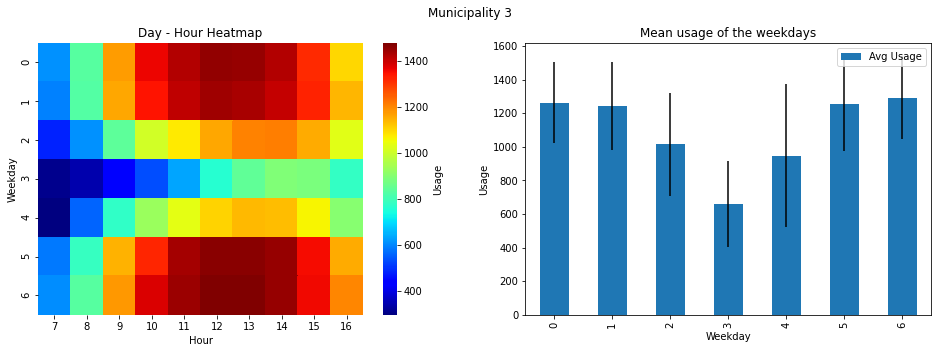

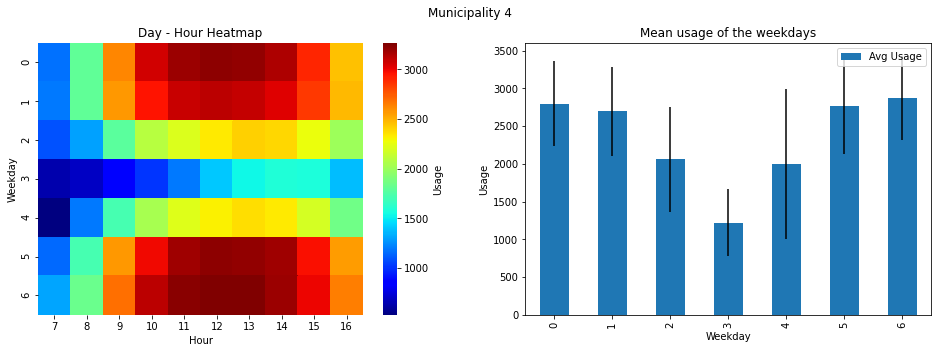

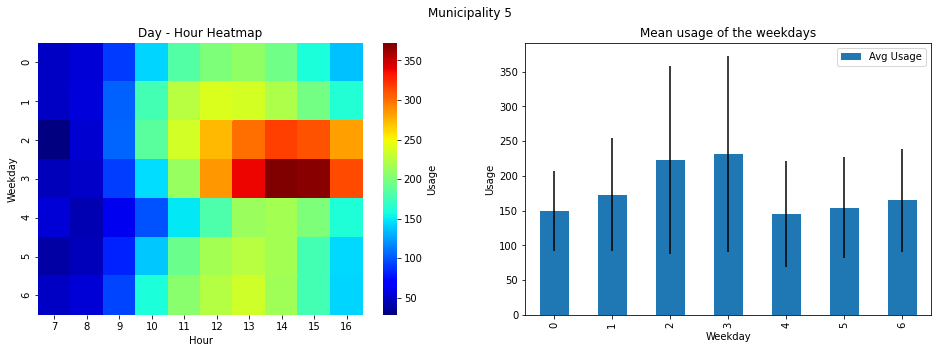

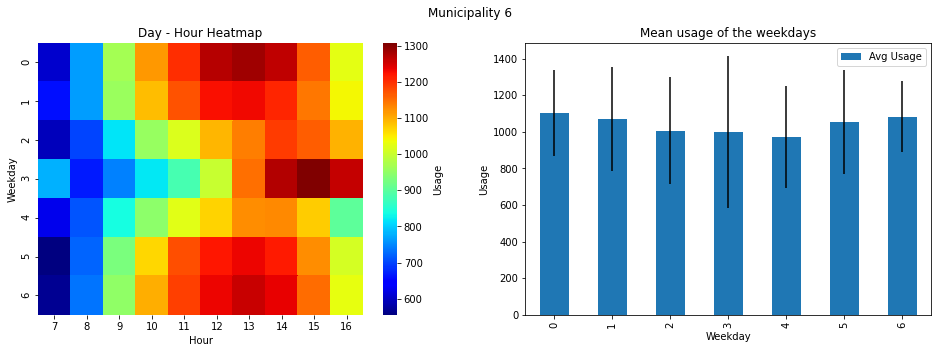

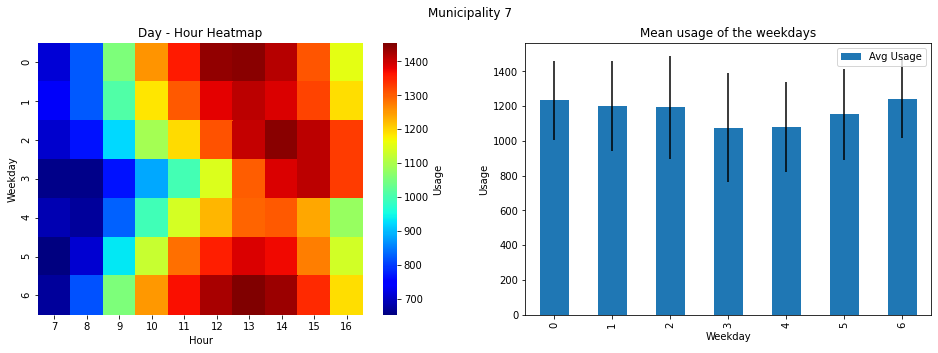

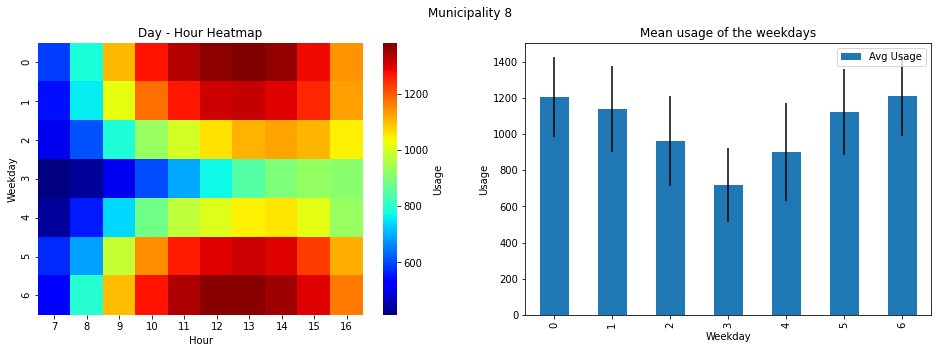

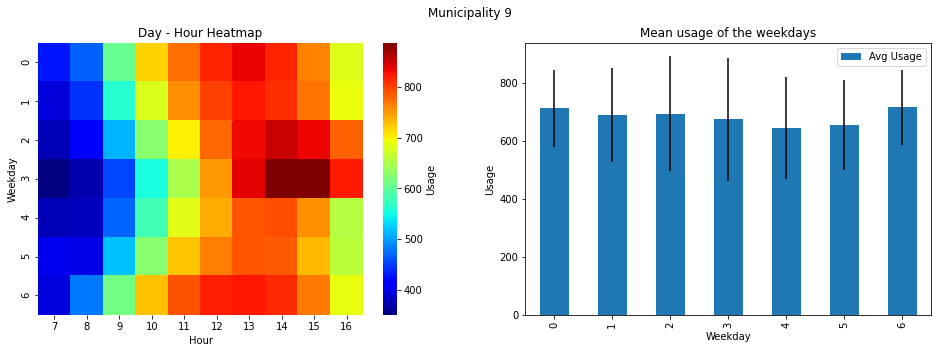

In [4]:
for mid in range(10):
    dh = df[mid].to_frame().pivot_table(
        index=[lambda x: x.weekday.rename("Weekday"),],
        columns=lambda x: x.hour, values='usage', aggfunc='mean'
        )
    dh.columns.name = 'Hour'
    dh.index.name = 'Weekday'
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    sns.heatmap(dh, cmap='jet', ax=ax[0], cbar_kws={'label': "Usage"})
    ax[0].set_title("Day - Hour Heatmap")
    df[mid].groupby(lambda x: x.weekday).agg(['mean', 'std']).rename({'mean':'Avg Usage'}, axis=1).plot(kind='bar', yerr='std', y='Avg Usage', ax=ax[1])

    ax[1].set_title("Mean usage of the weekdays")
    ax[1].set_xlabel("Weekday")
    ax[1].set_ylabel("Usage");
    fig.suptitle(f'Municipality {mid}')

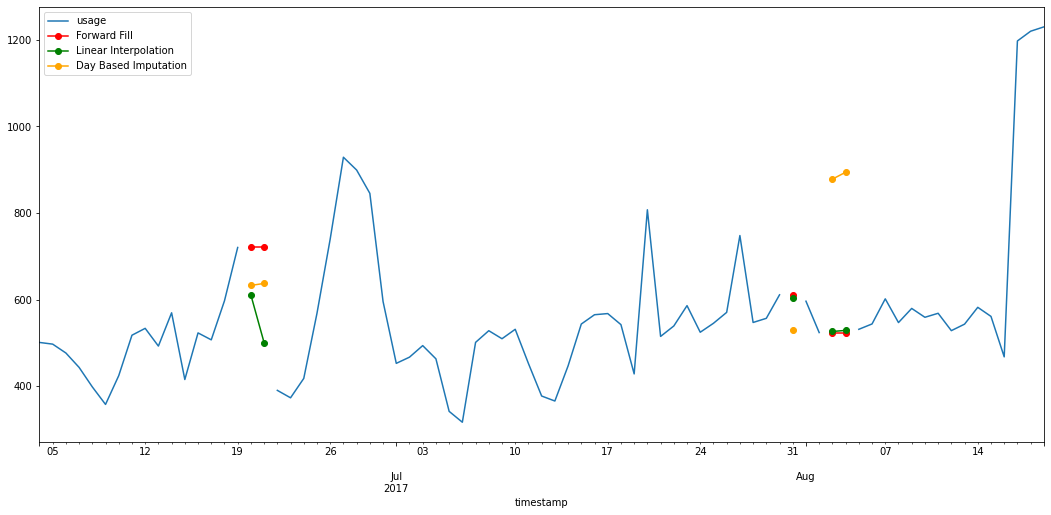

In [5]:
dm = df[0].resample('D').mean()

plt.figure(figsize=(18, 8))

dm.plot()

(dm.isna().loc[dm.isna()] * dm.ffill()).plot(color='red', marker='o', label='Forward Fill')
(dm.isna().loc[dm.isna()] * dm.interpolate()).plot(color='green', marker='o', label='Linear Interpolation')
(dm.isna().loc[dm.isna()] * dm.fillna(dm.groupby([lambda x: x.month, lambda x:x.weekday]).transform('mean'))).plot(color='orange', marker='o', label='Day Based Imputation')
plt.legend()

In [6]:
dm_filled = dm.fillna(dm.groupby([lambda x: x.month, lambda x:x.weekday]).transform('mean'))

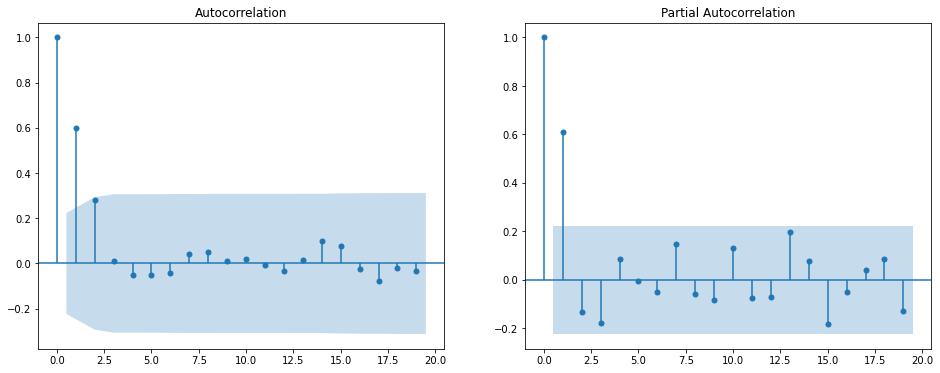

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sm.graphics.tsa.plot_acf(dm_filled, ax=ax[0]);
sm.graphics.tsa.plot_pacf(dm_filled, ax=ax[1]);

In [8]:
baseline_model1 = sm.tsa.SARIMAX(dm_filled.iloc[:-14], order=(1,0,0), name='trendy').fit()
baseline_model2 = sm.tsa.SARIMAX(dm_filled.iloc[:-14], order=(1,0,0), trend='c').fit()

In [9]:
display(baseline_model1.summary())
display(baseline_model2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                   63
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -395.924
Date:                Tue, 22 Jun 2021   AIC                            795.849
Time:                        21:43:26   BIC                            800.135
Sample:                    06-04-2017   HQIC                           797.534
                         - 08-05-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9728      0.026     38.074      0.000       0.923       1.023
sigma2      1.607e+04   2118.019      7.587      0.000    1.19e+04    2.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 7.43
Prob(Q):                              0.30   Prob(JB):                         0.02
Heteroskedasticity (H):               3.52   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  usage   No. Observations:                   63
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -387.233
Date:                Tue, 22 Jun 2021   AIC                            780.466
Time:                        21:43:26   BIC                            786.896
Sample:                    06-04-2017   HQIC                           782.995
                         - 08-05-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    230.0629     62.049      3.708      0.000     108.449     351.677
ar.L1          0.5774      0.095      6.084      0.000       0.391       0.763
sigma2      1.287e+04   2222.576      5.793      0.000    8518.142    1.72e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                11.52
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             0.85
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

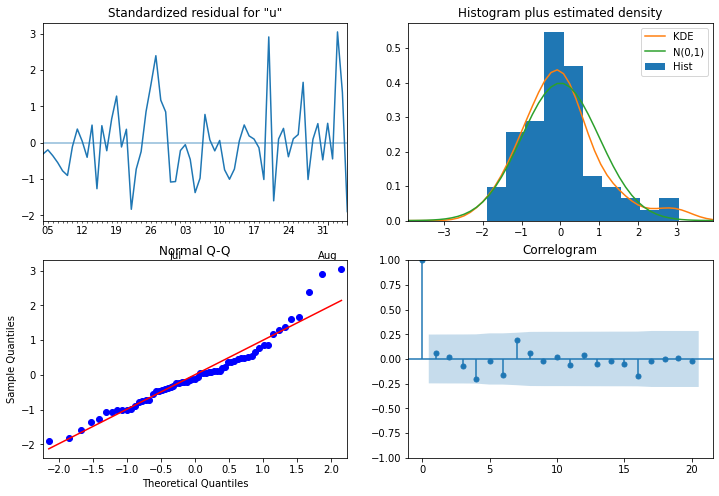

In [10]:
baseline_model2.plot_diagnostics(figsize=(12,8), lags=20);

In [11]:
sarimax = sm.tsa.SARIMAX(dm_filled.iloc[:-14], order=(1,1,1), seasonal_order=(1,2,1,7)).fit()

In [12]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             usage   No. Observations:                   63
Model:             SARIMAX(1, 1, 1)x(1, 2, 1, 7)   Log Likelihood                -317.279
Date:                           Tue, 22 Jun 2021   AIC                            644.557
Time:                                   21:43:29   BIC                            653.913
Sample:                               06-04-2017   HQIC                           648.093
                                    - 08-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998     16.926      0.059      0.953     -32.174      34.174
ma.L1         -0.9998     14.874     -0.067      0.946     -30.152      28.152
ar.S.L7       -0.2306      0.206     -1.117      0.264      -0.635       0.174
ma.S.L7       -0.9904      8.192     -0.121      0.904     -17.046      15.066
sigma2      2.316e+04      0.001   2.02e+07      0.000    2.32e+04    2.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.44   Prob(JB):                         0.41
Heteroskedasticity (H):               1.31   Skew:                             0.14
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.98e+25. Standard errors may be unstable.
"""

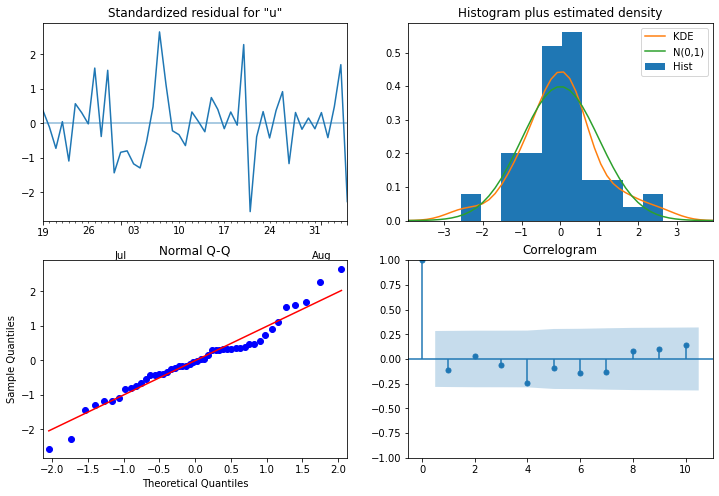

In [13]:
sarimax.plot_diagnostics(figsize=(12, 8));

In [14]:
decomp = sm.tsa.seasonal_decompose(sarimax.resid);

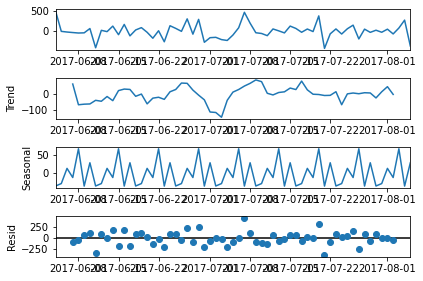

In [15]:
decomp.plot();

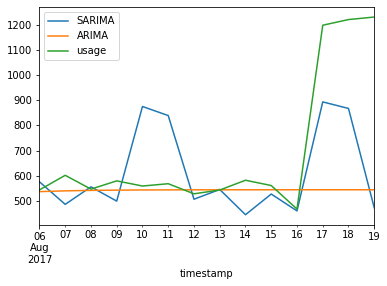

In [16]:
sarimax.predict(*dm_filled.iloc[-14:].iloc[[0, -1]].index.tolist()).rename('SARIMA').plot()
baseline_model2.predict(*dm_filled.iloc[-14:].iloc[[0, -1]].index.tolist()).rename('ARIMA').plot()
dm_filled.iloc[-14:].plot()
plt.legend()